In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import mkl

from numpy.typing import NDArray
from matplotlib.axes import Axes
from matplotlib.figure import Figure

# mkl.set_num_threads(2)
np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

In [3]:
# arrange 2D matrices as tiles (takes 4D `examples` tensor with dims: rows x cols x tile_height x tile_width)
def tiles(examples: NDArray) -> NDArray:
    rows, cols, h, w = examples.shape
    space = 2

    img_matrix = np.ones(shape=(rows * h + (rows - 1) * space, cols * w + (cols - 1) * space))

    for r in range(rows):
        for c in range(cols):
            x0 = r * w + r * space
            y0 = c * h + c * space
            img_matrix[x0 : x0 + w, y0 : y0 + w] = examples[r, c, :, :]

    return img_matrix

## MNIST Dataset

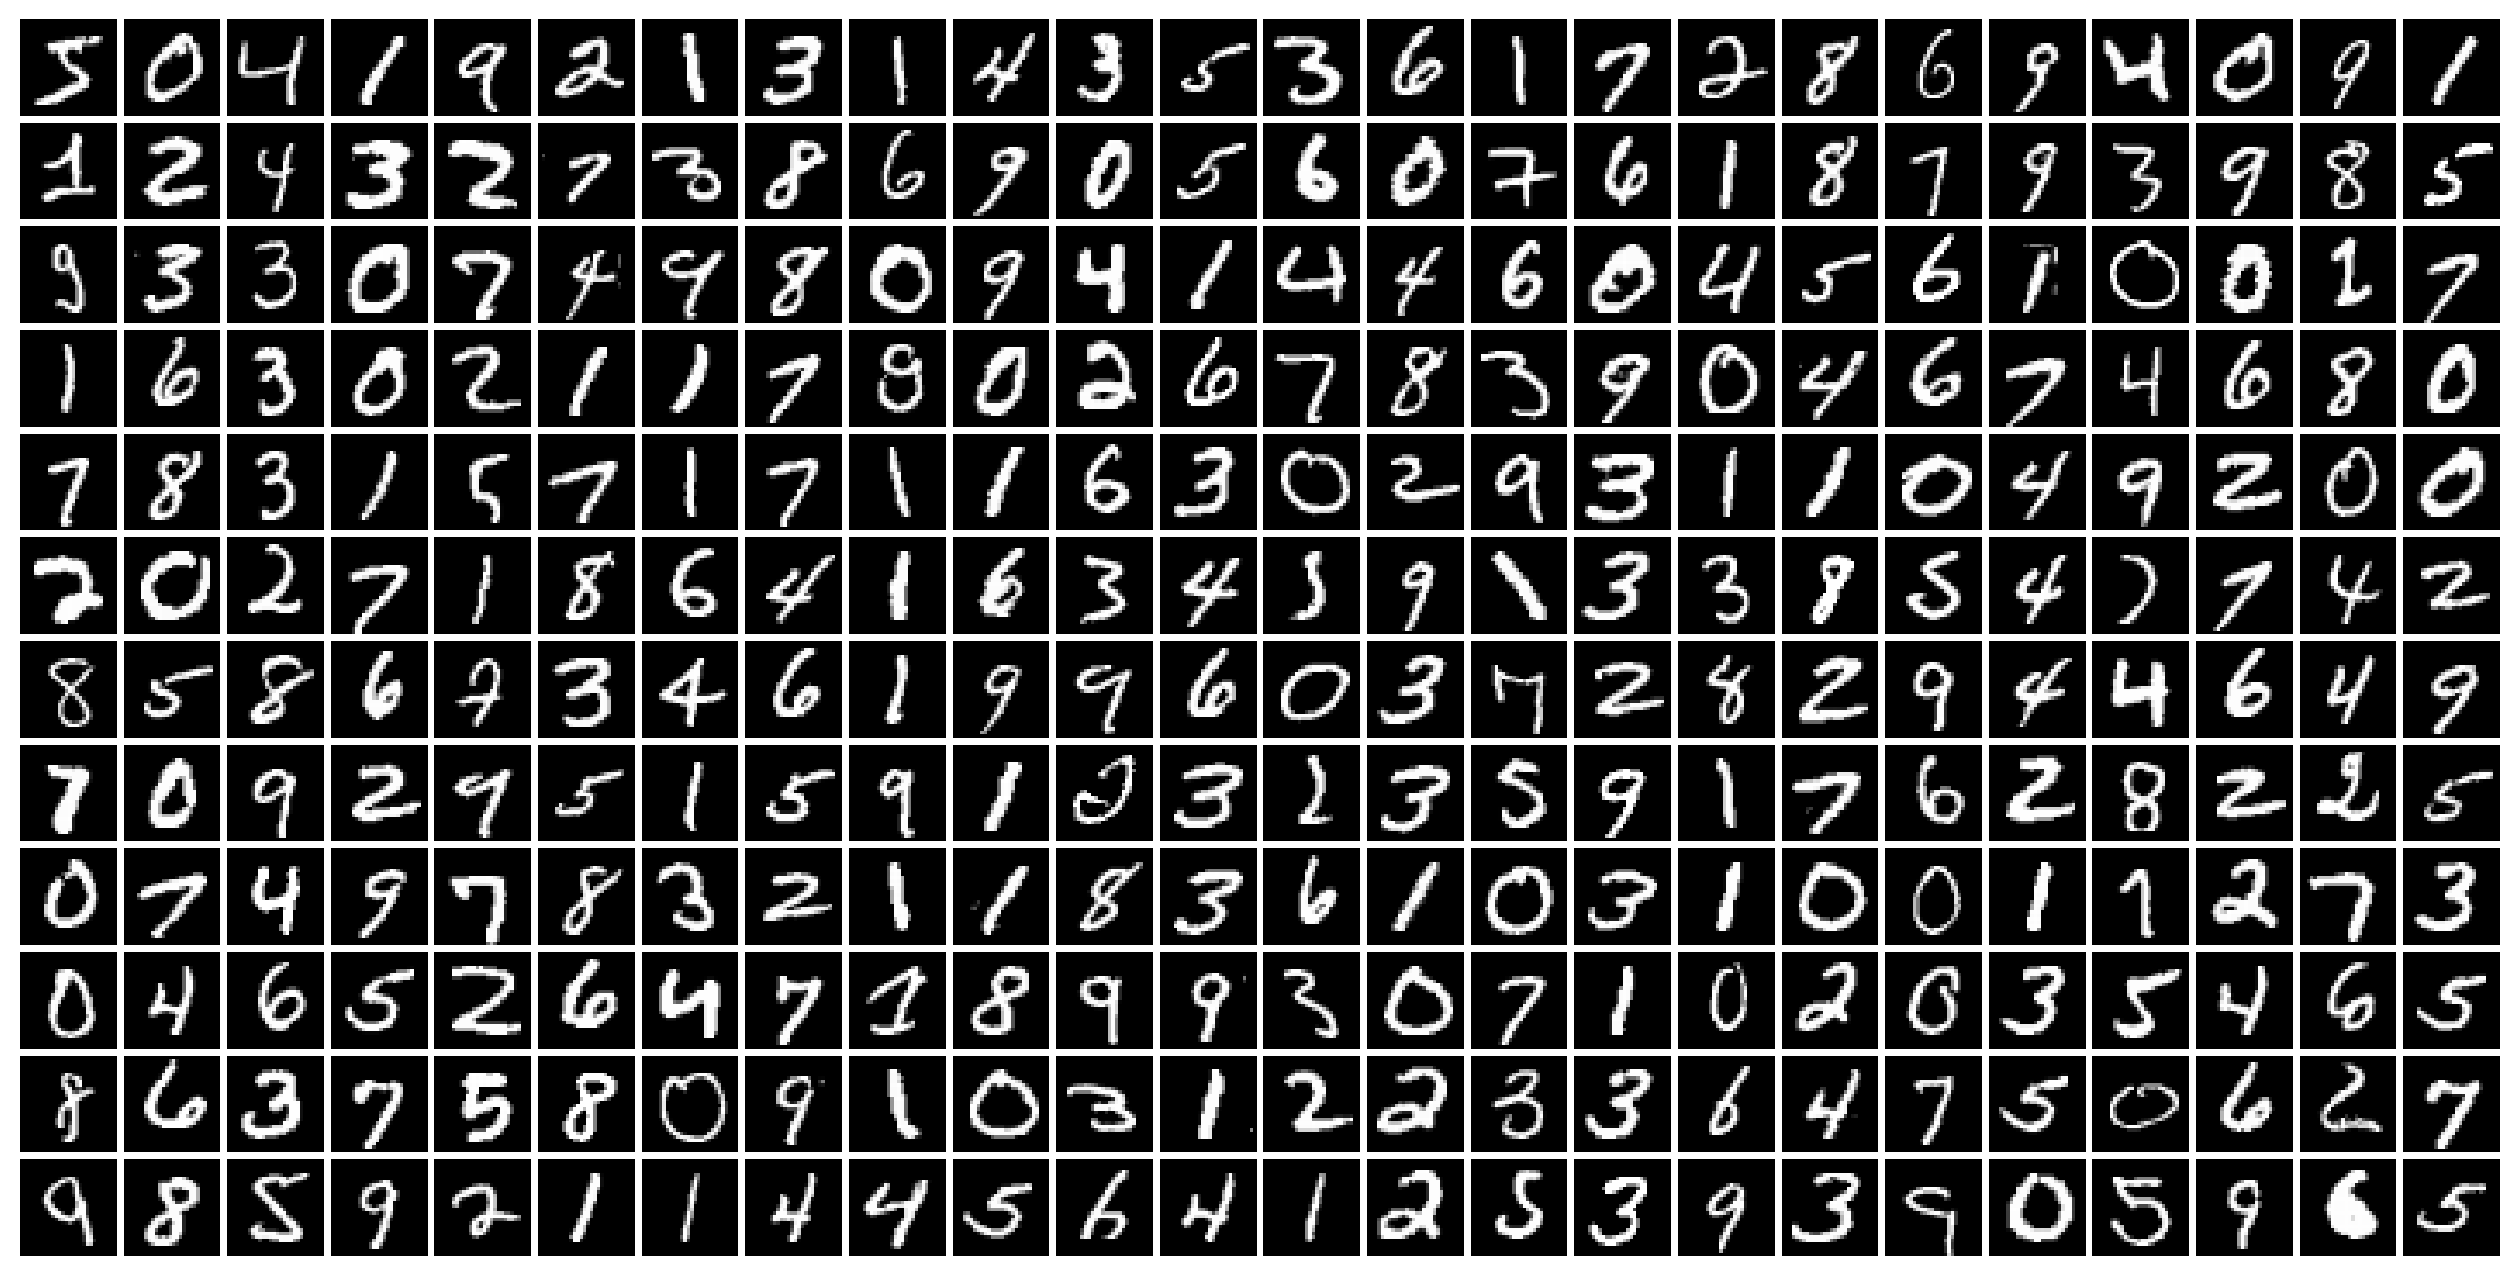

In [5]:
from mnists import MNIST

mnist = MNIST()

digits = mnist.train_images()[: 12 * 24].reshape(12, 24, 28, 28)
img = tiles(digits / 255.0)

plt.matshow(img, cmap="gray", interpolation="none")
plt.axis("off")
plt.show()

In [5]:
X = mnist.train_images().astype(np.float32) / 255.0
y = mnist.train_labels()
X.shape

(60000, 28, 28)

Reshape `X` so that the last two dimensions are collapsed into single dimension.

In [6]:
X = X.reshape(X.shape[0], -1)

In [7]:
X.shape

(60000, 784)

## Visualizing the distribution of MNIST digits

Add a scatter plot to `plot`, which:
* displys the first two dimensions of `X`,
* includes only these elements from `X` for which `y == i` (i.e. elements from the i-th class),
* includes label (i.e. `i`) in the legend.


In [8]:
def plot_2d_mnist_scatter(X: NDArray, y: NDArray):
    fig, plot = plt.subplots()
    fig.set_size_inches(16, 16)
    plt.prism()

    for i in range(10):
        mask = y == i
        plot.scatter(X[mask, 0], X[mask, 1], label=f"{i}")

    plot.set_xticks(())
    plot.set_yticks(())

    plt.tight_layout()
    plt.legend()
    plt.show()

### Principal Component Analysis (PCA)

In [9]:
SAMPLES_LIMIT = 2000
X_small = X[:SAMPLES_LIMIT]
y_small = y[:SAMPLES_LIMIT]

Use PCA function to embed `X_small` in two dimensions. Store the result in `X_pca_embedded`.

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
X_pca_embedded = pca.fit_transform(X_small)

In [11]:
X_pca_embedded.shape

(2000, 2)

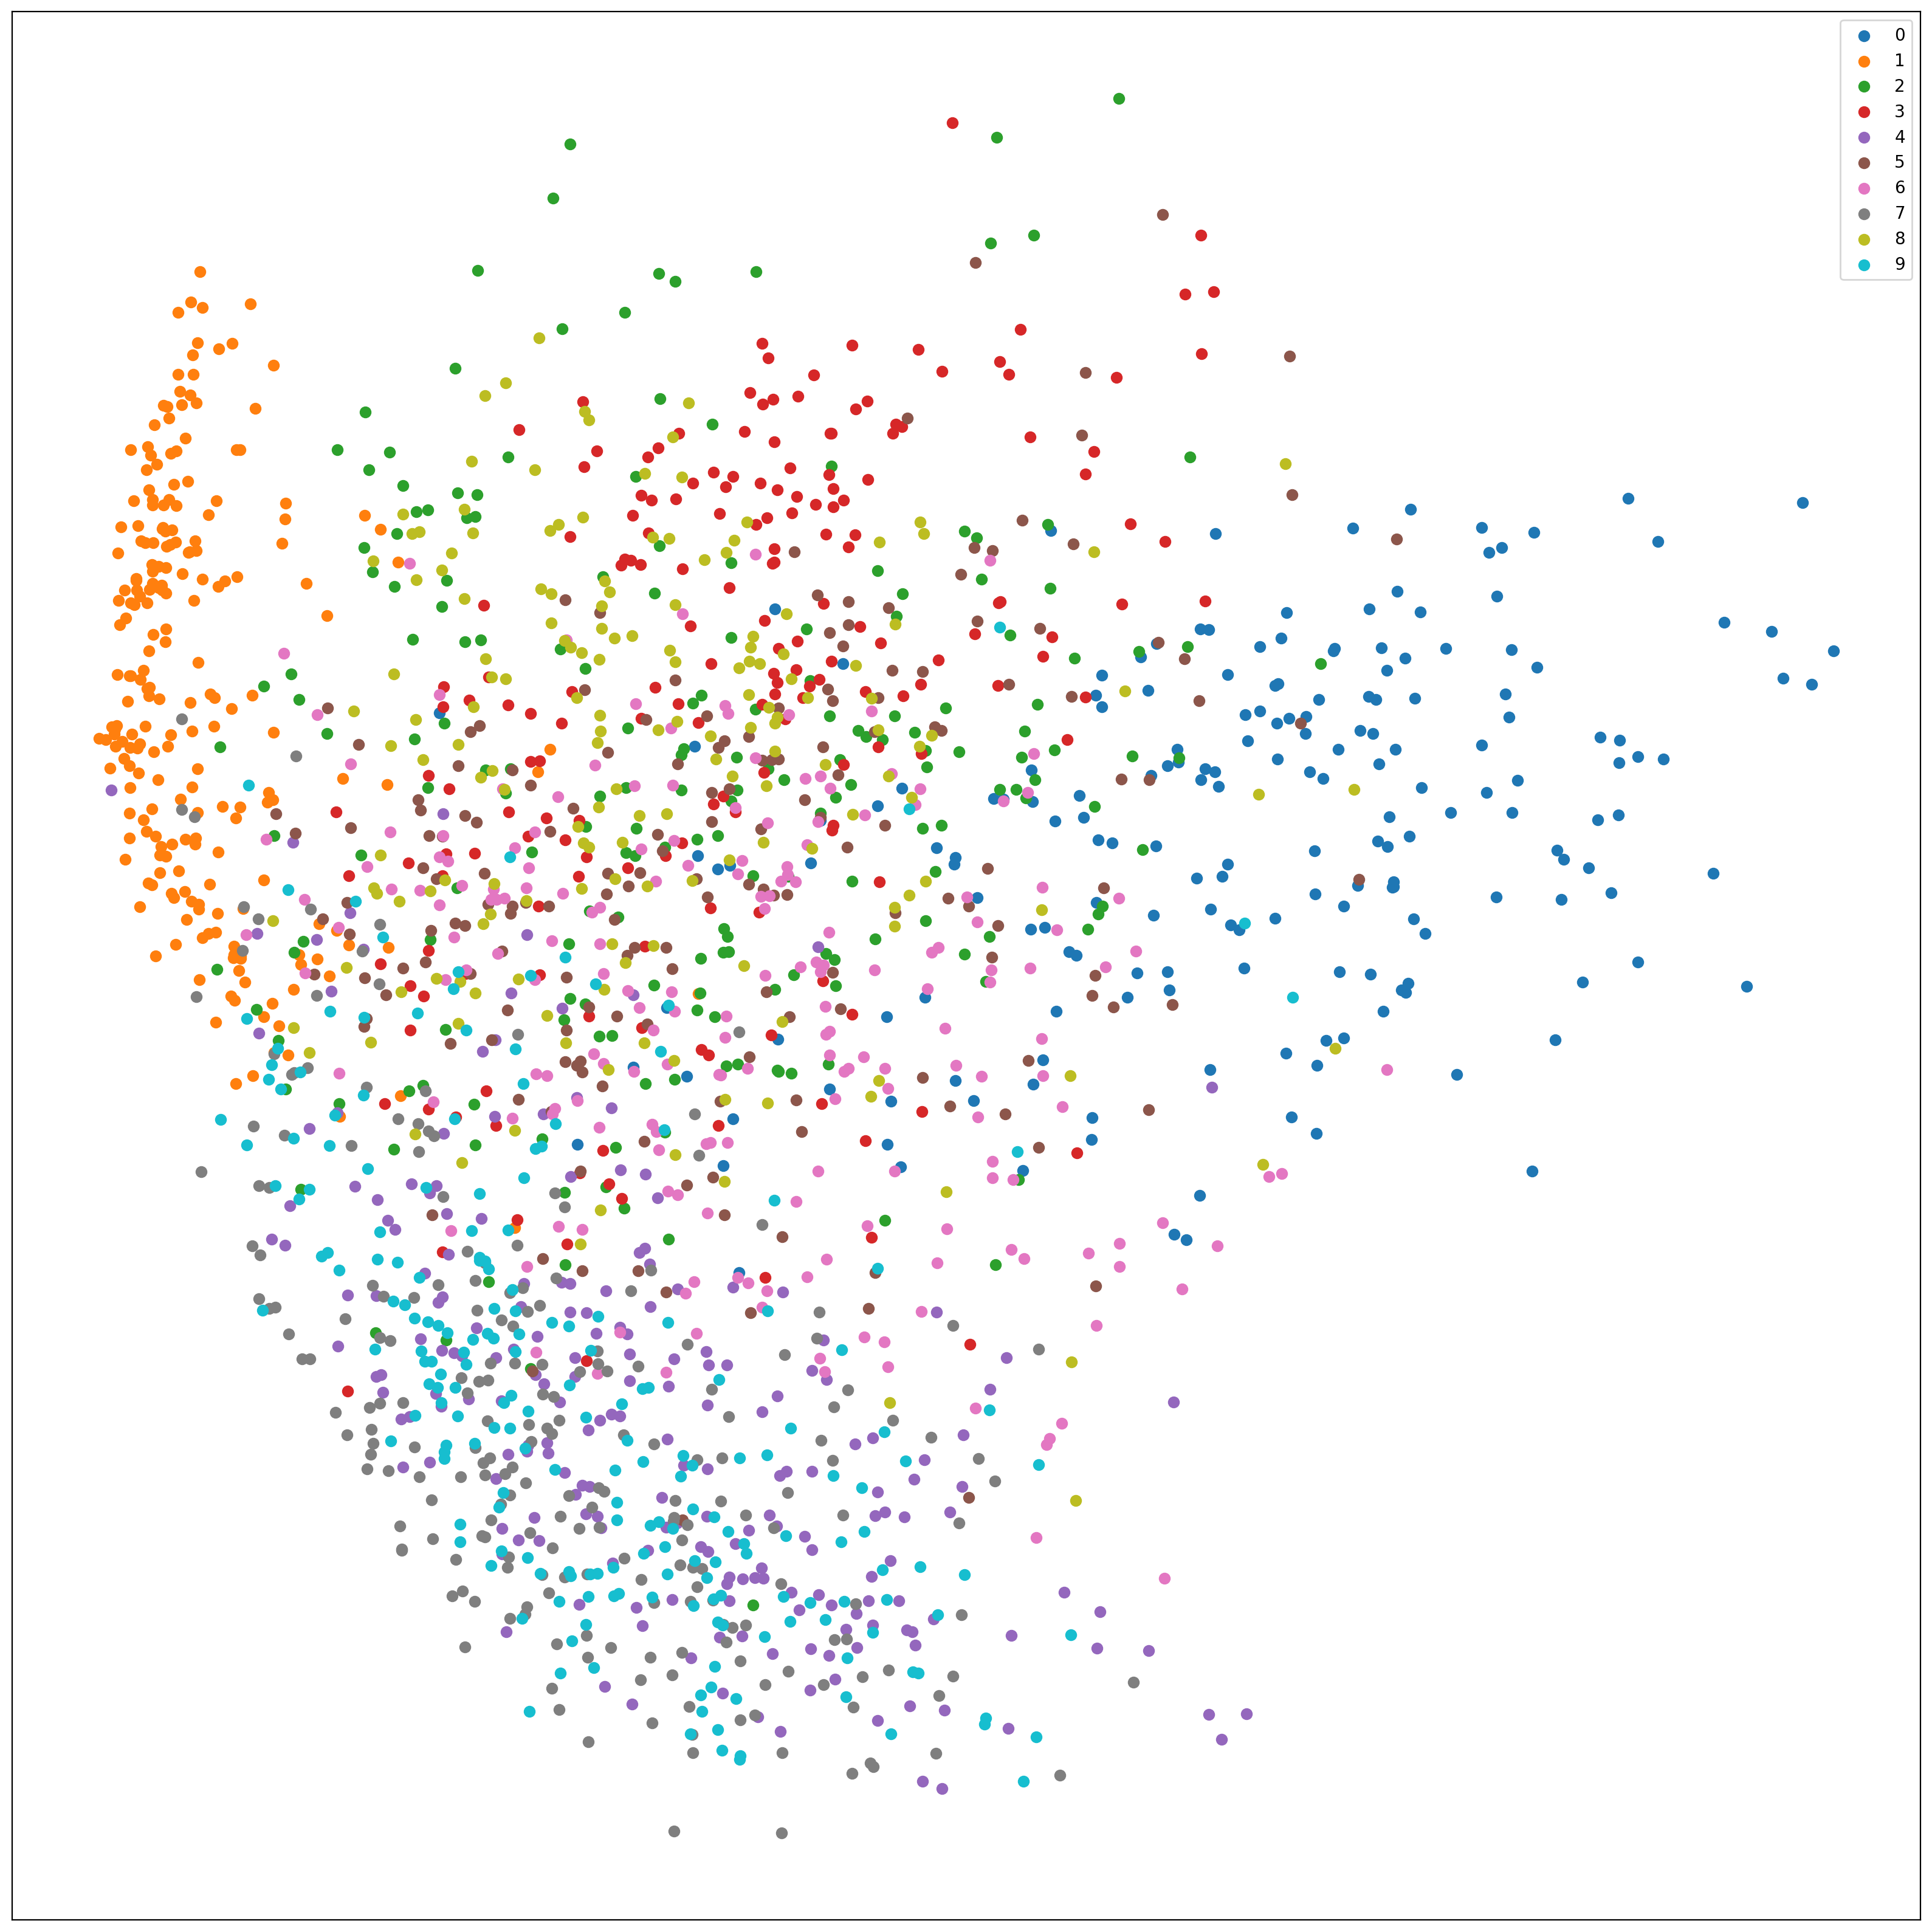

In [12]:
plot_2d_mnist_scatter(X_pca_embedded, y_small)

### T-distributed Stochastic Neighbour Embedding (T-SNE)

Make sure to have a look on this increadible [article on T-SNE](https://distill.pub/2016/misread-tsne/).

Use `T-SNE` function to embed `X_small` in two dimensions. Store the result in `X_tsne_embedded`. <BR>
Use:
 * `n_iter=500` argument to limit the number of T-SNE iterations, 
 * `verbose=2` argument to see a verbose output during embedding.

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, max_iter=500, verbose=2)
X_tsne_embedded = tsne.fit_transform(X_small)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.090s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.528207
[t-SNE] Computed conditional probabilities in 0.028s
[t-SNE] Iteration 50: error = 77.8449936, gradient norm = 0.0138680 (50 iterations in 0.119s)
[t-SNE] Iteration 100: error = 75.6764908, gradient norm = 0.0004129 (50 iterations in 0.086s)
[t-SNE] Iteration 150: error = 75.6504517, gradient norm = 0.0006917 (50 iterations in 0.086s)
[t-SNE] Iteration 200: error = 75.5896683, gradient norm = 0.0006408 (50 iterations in 0.096s)
[t-SNE] Iteration 250: error = 75.5473785, gradient norm = 0.0003428 (50 iterations in 0.091s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.547379
[t-SNE] Iteration 300: error = 1.7908239, gradient norm = 0.0210654 (50 iterations in 0.091s)

In [14]:
X_tsne_embedded.shape

(2000, 2)

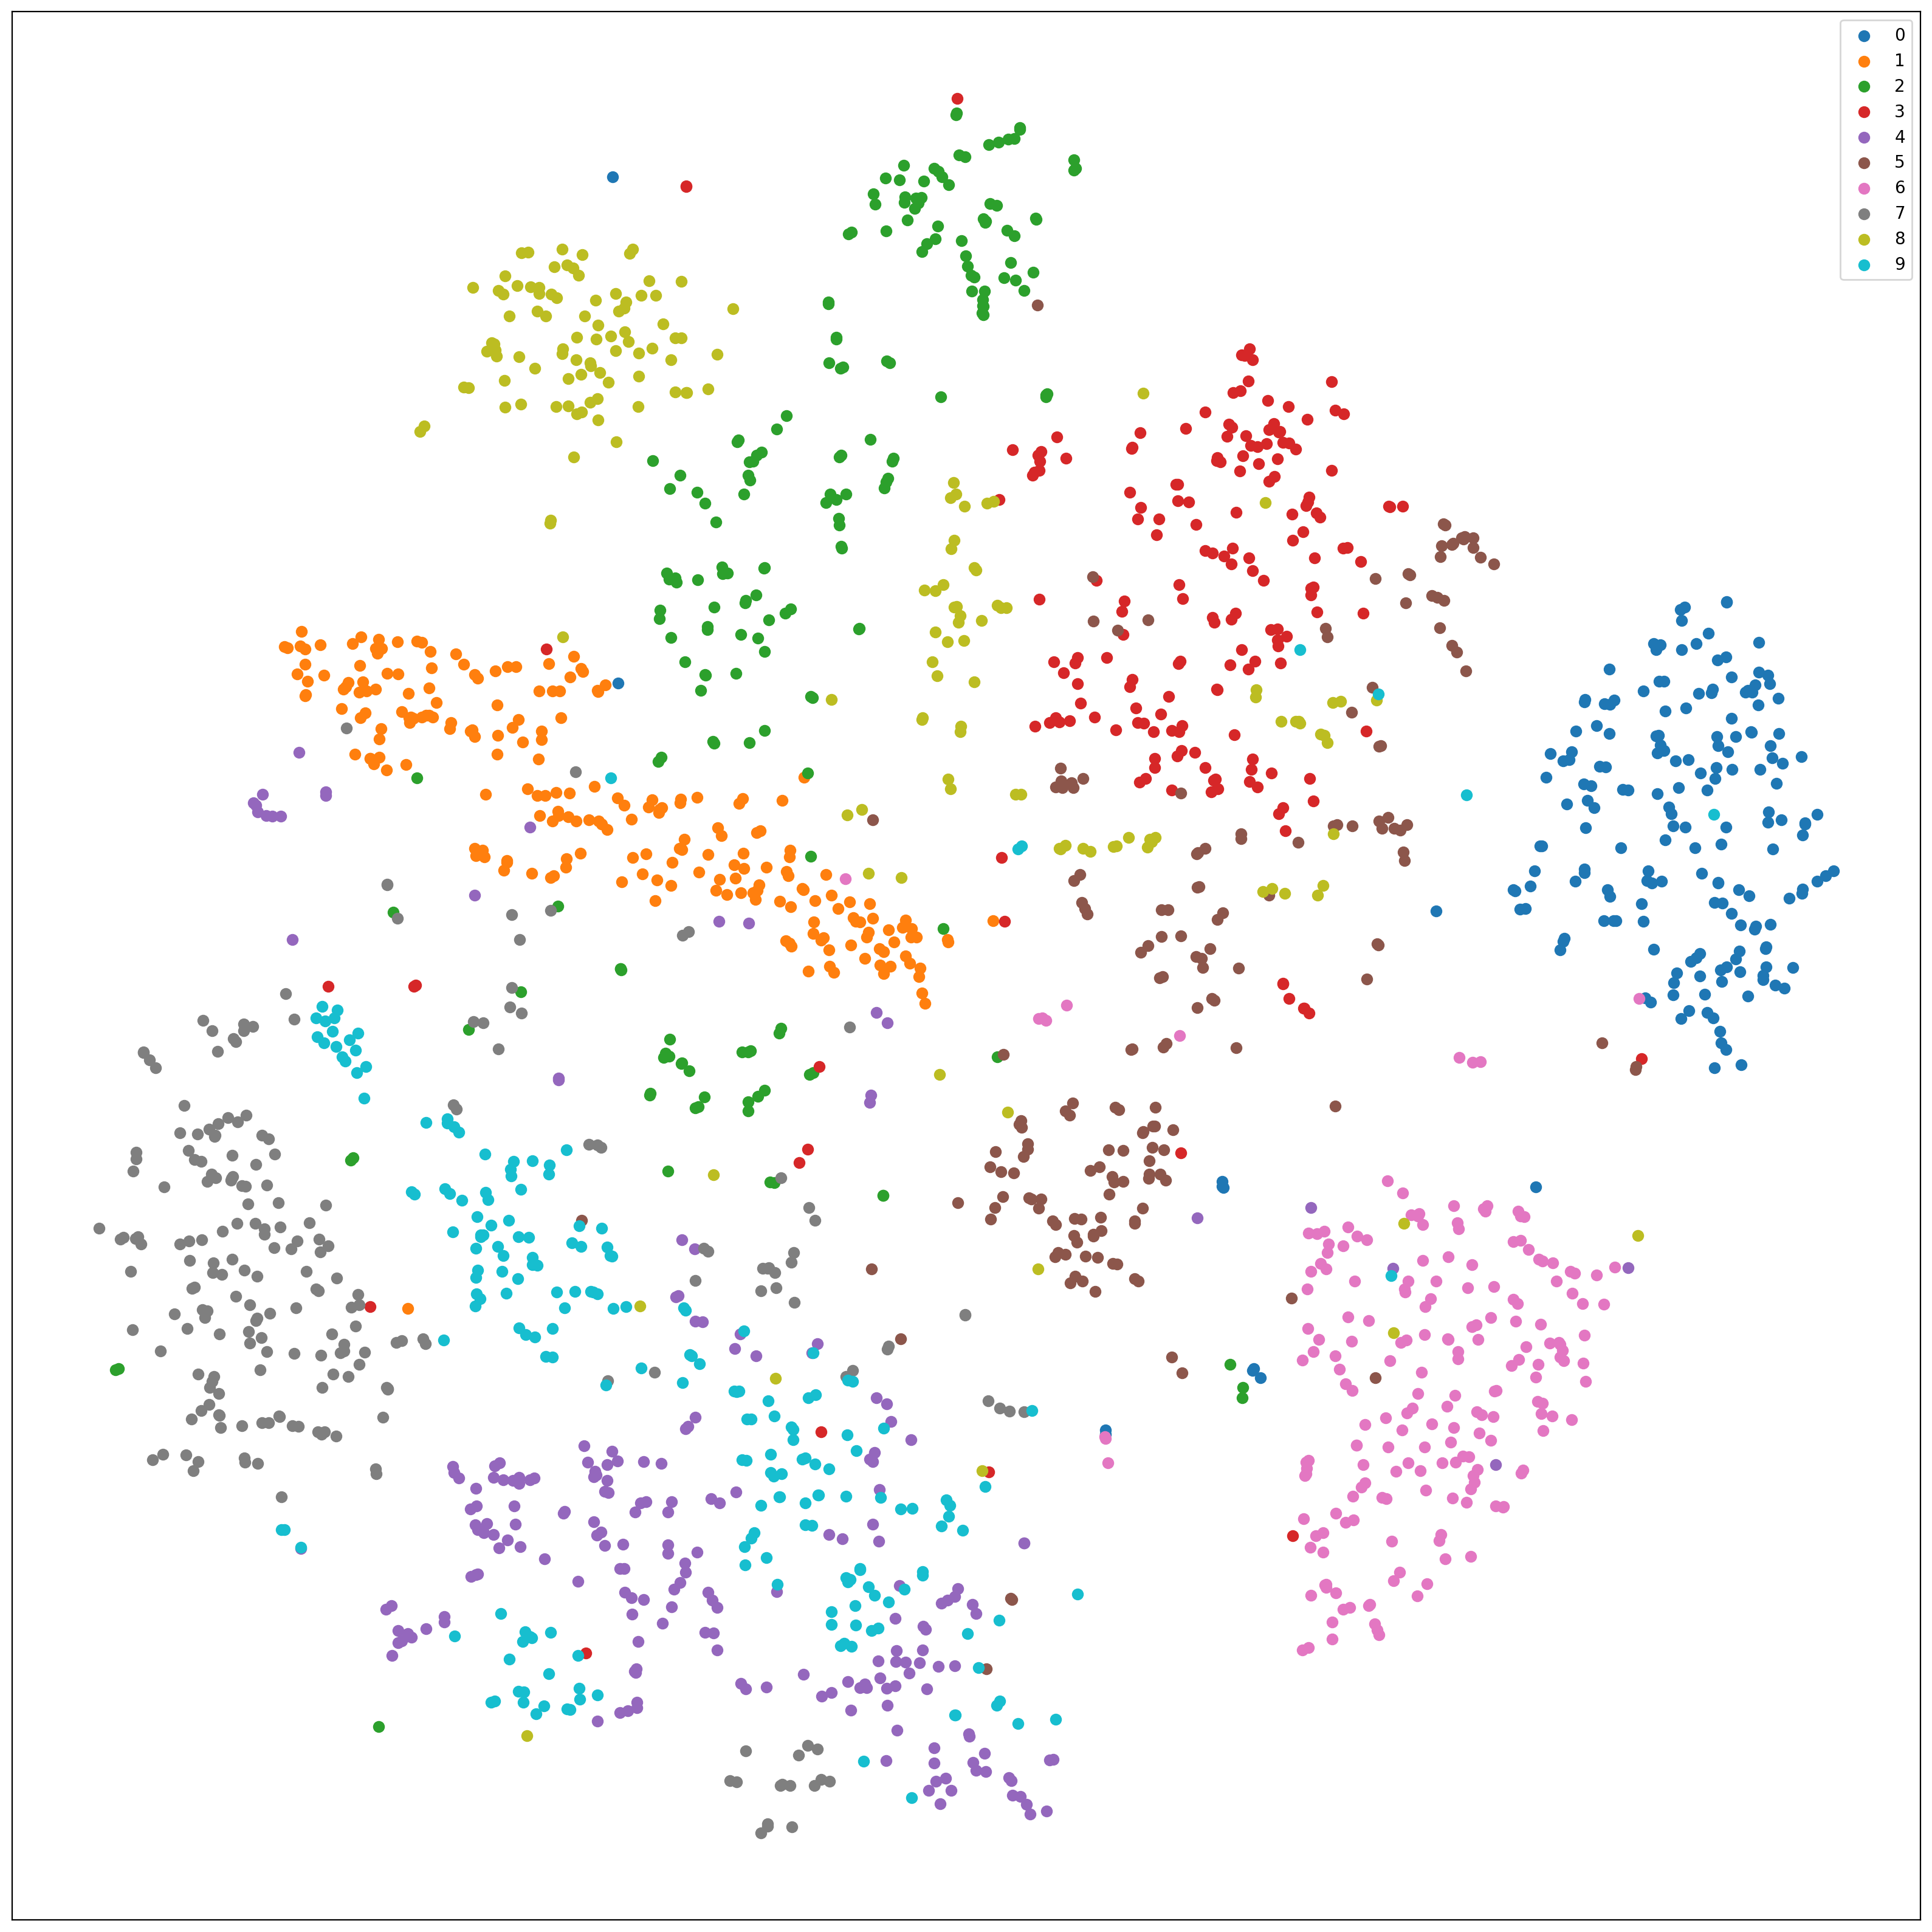

In [15]:
plot_2d_mnist_scatter(X_tsne_embedded, y_small)

### 3D interactive plots with plotly

In [16]:
import plotly.io as pio
import plotly.graph_objs as go

from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)
# pio.renderers.default = "iframe"


def plot_3d_mnist_plotly_scatter(X: NDArray, y: NDArray):
    def make_trace(i):
        digit_indices = y == i
        return go.Scatter3d(
            x=X[digit_indices, 0],
            y=X[digit_indices, 1],
            z=X[digit_indices, 2],
            mode="markers",
            name=str(i),
            marker=dict(
                color=i, colorscale="Jet", size=4, symbol="circle", line=dict(color="rgb(204, 204, 204)", width=1)
            ),
        )

    traces = [make_trace(i) for i in range(10)]

    layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)

Use PCA function to embed `X_small` in **three** dimensions. Store the result in `X_3d_pca_embedded`.

In [17]:
pca_3d = PCA(n_components=3, random_state=0)
X_3d_pca_embedded = pca_3d.fit_transform(X_small)

In [18]:
X_3d_pca_embedded.shape

(2000, 3)

In [19]:
plot_3d_mnist_plotly_scatter(X_3d_pca_embedded, y_small)

## Classification task

In [20]:
from sklearn.model_selection import train_test_split
SAMPLES_LIMIT=10000
X_train, X_test, y_train, y_test = train_test_split(X[:SAMPLES_LIMIT], y[:SAMPLES_LIMIT], test_size=0.2)

In [ ]:
from sklearn import svm

clf = svm.SVC(C=1, gamma=0.001, random_state=0)
clf.fit(X_train, y_train)

SVC(C=1, gamma=0.001)

In [22]:
from sklearn import metrics

y_pred = clf.predict(X_test)
print(f"Classification report for classifier {clf}:\n{metrics.classification_report(y_test, y_pred)}\n")

Classification report for classifier SVC(C=1, gamma=0.001):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       178
           1       0.89      0.97      0.93       215
           2       0.90      0.89      0.90       196
           3       0.90      0.85      0.87       190
           4       0.90      0.92      0.91       206
           5       0.88      0.91      0.89       206
           6       0.94      0.98      0.96       202
           7       0.93      0.90      0.91       222
           8       0.96      0.85      0.90       188
           9       0.88      0.89      0.88       197

    accuracy                           0.91      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.91      0.91      2000




Calculate and display the confision matrix for `predicted` and `y_test` (use metrics package).

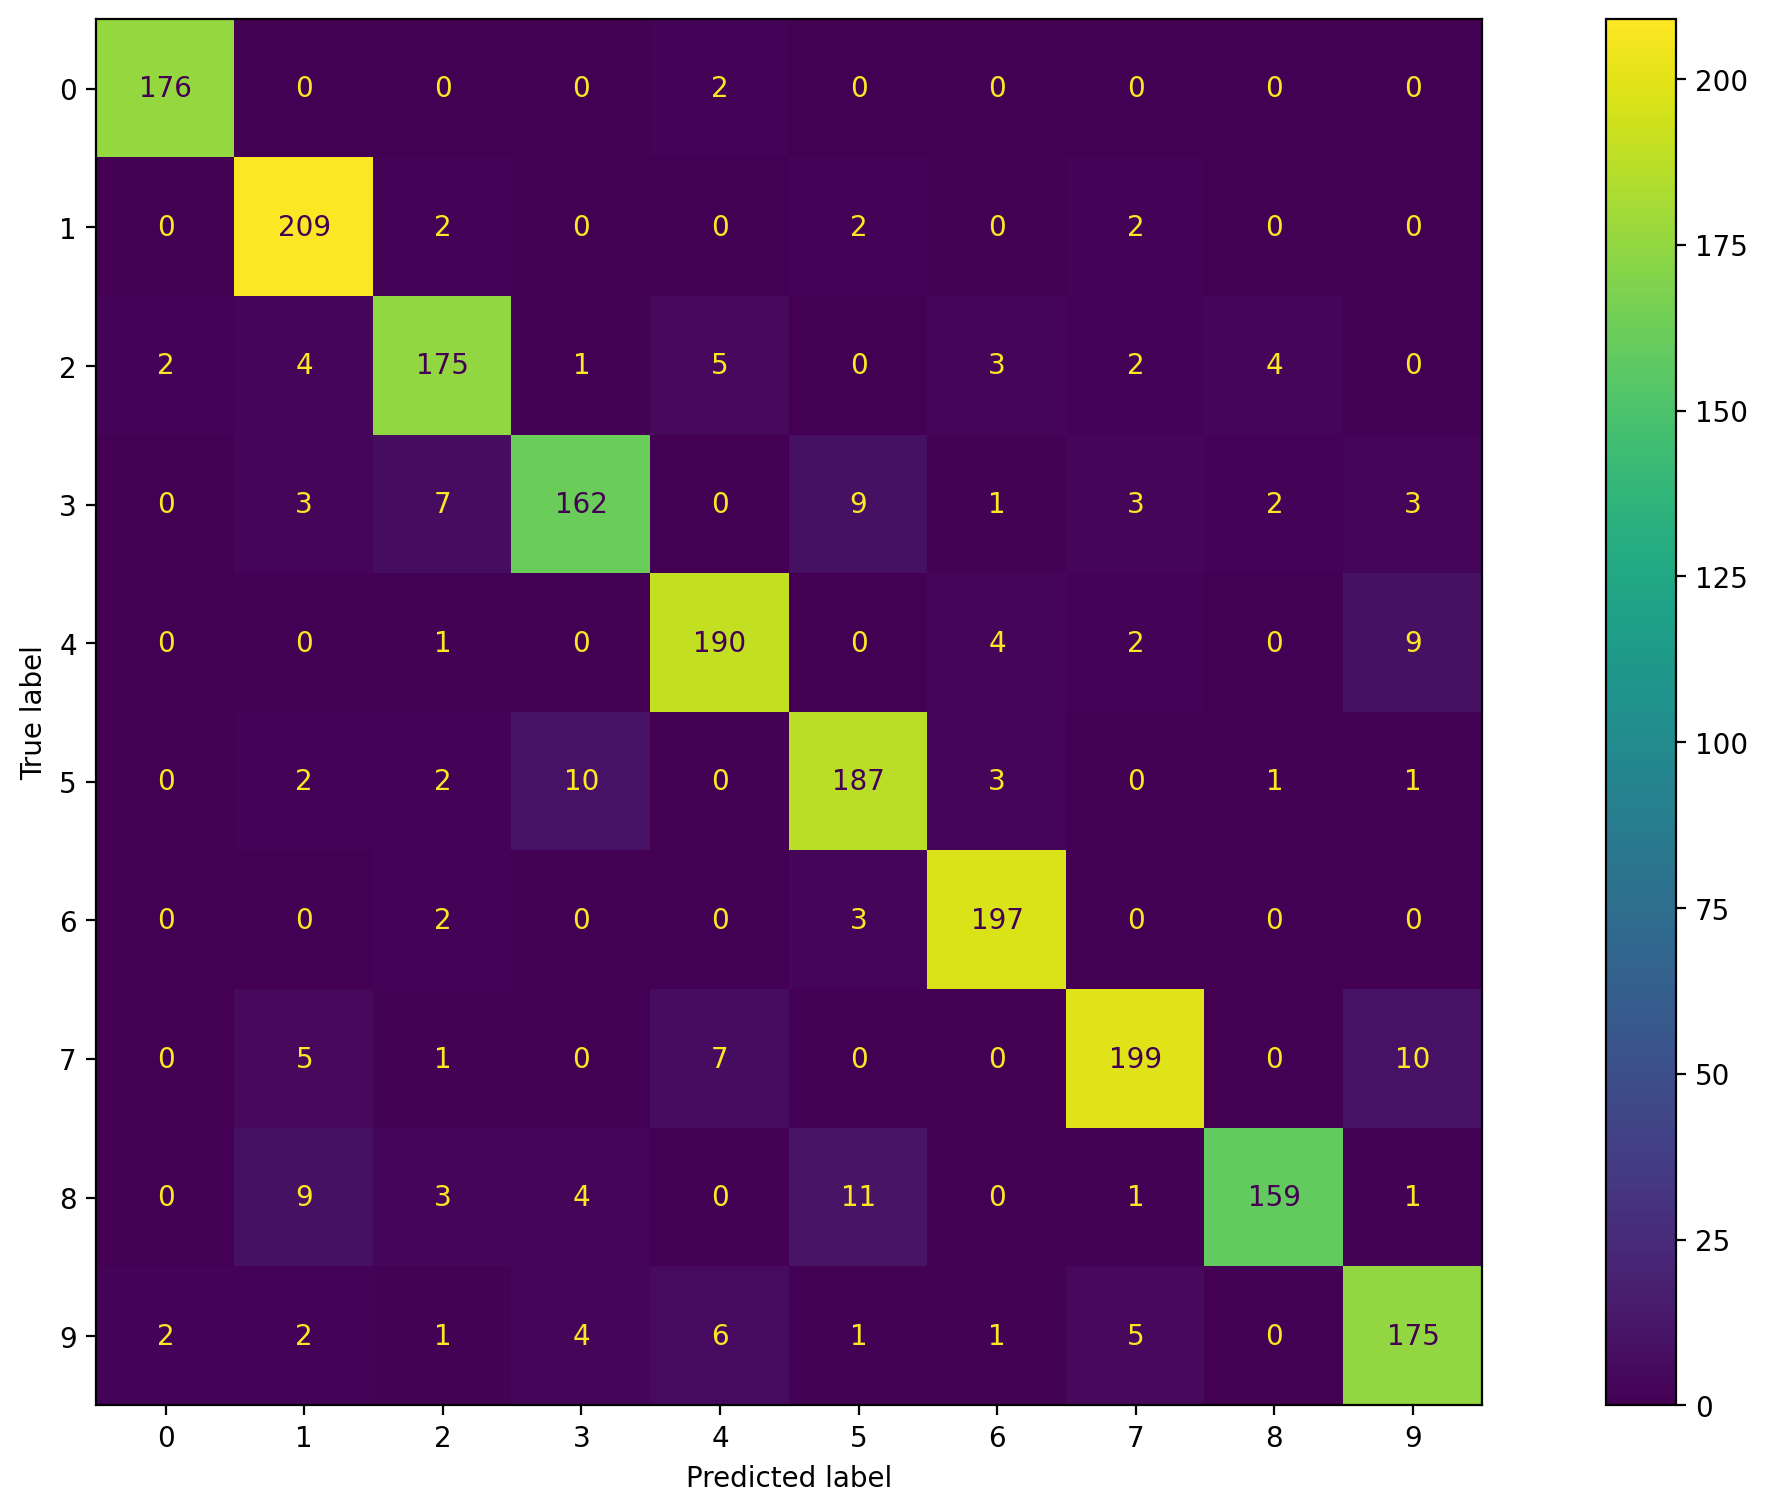

In [23]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
disp.plot();